In [2]:
import pymc3 as pm
import numpy as np
import pandas as pd
import scipy as sci
import theano.tensor as tt
import matplotlib.pyplot as plt
import theano
import math

WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [3]:
data = pd.read_excel("ActualDataFeb2020.xlsx")

In [4]:
data.head()

,Дата - Время,Gpp,Tpp,Gp4,Go4,Tp4,T04,Gp5,Go5,Tp5,...,GpSN4,GoSN4,TpSN4,ToSn4,GpSN5,GoSN5,TpSN5,ToSN5,GoSN2,ToSN2
0,12.02.2020 - 00:00:00,309.94,107.65,1922,2042,109.35,63.53,1172,779,112.04,...,276.85,151.91,99.15,83.48,219.48,293.34,111.62,88,66.78,82
1,12.02.2020 - 00:10:00,315.52,107.42,1920,2042,109.47,63.55,1172,777,111.99,...,276.70,151.86,99.17,83.49,219.41,292.78,111.64,88,47.67,82
2,12.02.2020 - 00:20:00,308.43,107.32,1922,2044,109.50,63.59,1181,788,112.02,...,276.35,151.41,99.22,83.50,219.10,290.53,111.59,88,38.99,82
3,12.02.2020 - 00:30:00,320.57,107.29,1912,2039,109.39,63.61,1174,775,111.87,...,276.49,152.67,98.99,83.15,220.24,290.94,111.57,88,39.03,82
4,12.02.2020 - 00:40:00,320.70,107.32,1915,2043,109.37,63.62,1173,762,112.00,...,276.69,152.60,98.91,83.29,220.06,292.38,111.54,88,47.67,82


In [98]:
min=np.min([int(np.min(data['Go2'])),int(np.min(data['GoSN2'])),int(np.min(data['Gp2']))])
max=np.max([int(np.max(data['Go2'])),int(np.max(data['GoSN2'])),int(np.max(data['Gp2']))])


Go2_range = np.array([i for i in range(min,max+1)])
Go2_data = np.array([len(data[(data['Go2'] > temp-0.5) & (data['Go2'] <= temp+0.5)])
                     for temp in Go2_range])



GoSN2_range = np.array([i for i in range(min,max+1)])
GoSN2_data = np.array([len(data[(data['GoSN2'] > temp-0.5) & (data['GoSN2'] <= temp+0.5)])
                     for temp in GoSN2_range])



Gp2_range = np.array([i for i in range(min,max+1)])
Gp2_data = np.array([len(data[(data['Gp2'] > temp-0.5) & (data['Gp2'] <= temp+0.5)])
                     for temp in Gp2_range])

In [99]:
np.min([int(np.min(data['Go2'])),int(np.min(data['GoSN2'])),int(np.min(data['Gp2']))])

0

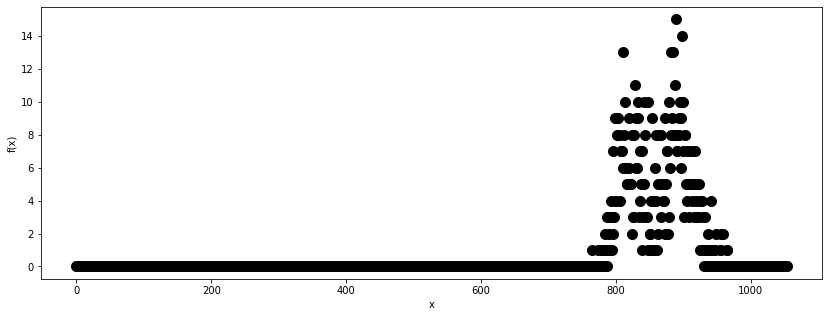

In [100]:
fig = plt.figure(figsize=(14,5)); ax = fig.add_subplot(111)
ax.plot(Go2_range, Go2_data, 'ok', ms=10);
ax.set_xlabel("x");
ax.set_ylabel("f(x)");

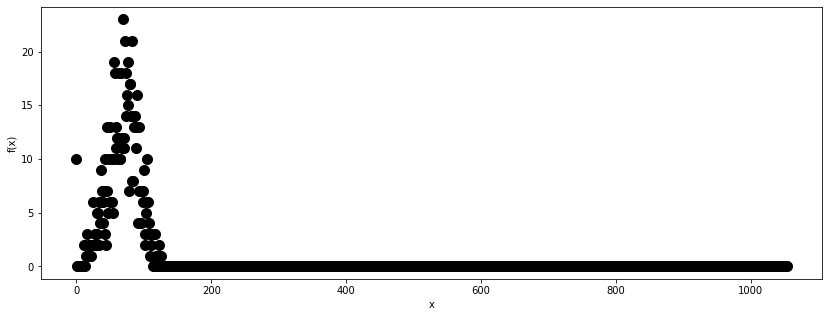

In [101]:
fig = plt.figure(figsize=(14,5)); ax = fig.add_subplot(111)
ax.plot(GoSN2_range, GoSN2_data, 'ok', ms=10);
ax.set_xlabel("x");
ax.set_ylabel("f(x)");

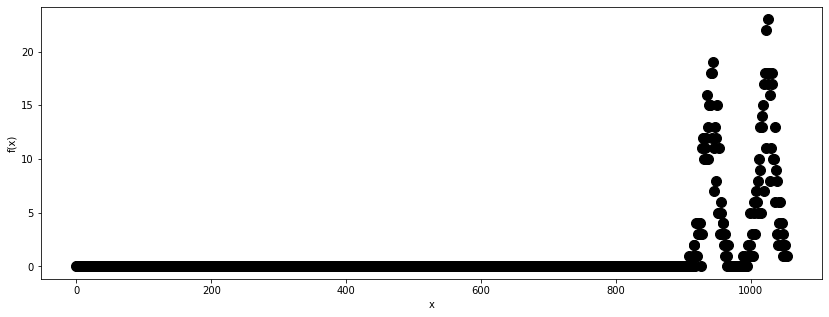

In [102]:
fig = plt.figure(figsize=(14,5)); ax = fig.add_subplot(111)
ax.plot(Gp2_range, Gp2_data, 'ok', ms=10);
ax.set_xlabel("x");
ax.set_ylabel("f(x)");

In [104]:
with pm.Model() as model:
    ############
    #Go2
    p1 = pm.Exponential('p1',1)
    n1 = pm.Exponential('n1',1)
    
    K1 = n1**2 * pm.gp.cov.ExpQuad(1,p1)
    
    gp1 = pm.gp.Latent(cov_func=K1)
    f1 = gp.prior('f1', X=Go2_range[:, None])
    
    l1 = pm.Deterministic('l1',tt.exp(f1))
    
    Go2 = pm.Poisson('Go2', l1, observed=Go2_data)
    ###############
    #GoSN2
    p = pm.Exponential('p',1)
    n = pm.Exponential('n',1)
    
    K = n**2 * pm.gp.cov.ExpQuad(1,p)
    
    gp = pm.gp.Latent(cov_func=K)
    f = gp.prior('f', X=GoSN2_range[:, None])
    
    l = pm.Deterministic('l',tt.exp(f))
    
    GoSN2 = pm.Poisson('GoSN2', l, observed=GoSN2_data)
    ###############
    #Gp2
    Gp2 = pm.Deterministic('Gp2', Go2+GoSN2)
    
    
    p2_ = pm.Exponential('p2_',1)
    n2_ = pm.Exponential('n2_',1)
    
    K2_ = n2_**2 * pm.gp.cov.ExpQuad(1,p2_)
    
    gp2_ = pm.gp.Latent(cov_func=K2_)
    f2_ = gp.prior('f2_', X=Gp2_range[:, None])
    
    l2_ = pm.Deterministic('l2_',tt.exp(f2))
    
    Gp2_ = pm.Poisson('Gp2_', l2, observed=Gp2_data)
    

In [106]:
with model:
    fit = pm.find_MAP(exception_verbosity='high')

MissingInputError: Input 0 of the graph (indices start from 0), used to compute Elemwise{exp,no_inplace}(n_log__), was not provided and not given a value. Use the Theano flag exception_verbosity='high', for more information on this error.

In [11]:
fit

{'p_log__': array(-0.2099364),
 'n_log__': array(2.05294145),
 'f_rotated_': array([-0.00303813, -0.43945191, -0.29554383, -0.32009479, -0.3479266 ,
        -0.21754719,  0.147744  ,  0.03170163,  0.07147391, -0.4258458 ,
         0.24654282,  0.0864156 , -0.06306843,  0.19501372,  0.09495524,
         0.13752856,  0.11963026,  0.08078565, -0.40916876,  0.40093755,
         0.14551328,  0.25970005,  0.17956684,  0.24765231,  0.19899473,
         0.20947308,  0.2336522 ,  0.26157083,  0.17310085,  0.2632755 ,
         0.23654667,  0.24682124,  0.24233825,  0.27161449,  0.19376369,
         0.29911664,  0.24909878,  0.12310818,  0.26873704,  0.21511792,
         0.22575945,  0.16242041,  0.29320577,  0.05556521,  0.30631382,
         0.05386761,  0.11223226,  0.16969137,  0.15906373,  0.05838262,
         0.16189029,  0.10597325,  0.0313914 ,  0.13655017, -0.07689362,
         0.13580131, -0.44896993,  0.25609658, -0.0229298 , -0.44822263,
        -0.2904344 , -0.32448746, -0.31927135, -

In [12]:
with model:
    step = pm.NUTS()
    trace = pm.sample(100,tune=100, chains =2)

/home/danil/.local/lib/python3.6/site-packages/theano/tensor/basic.py:6611: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result[diagonal_slice] = x
/home/danil/.local/lib/python3.6/site-packages/theano/tensor/basic.py:6611: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result[diagonal_slice] = x
Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 4 jobs)
NUTS: [f_rotated_, n, p]
Sampling 2 chains, 0 divergences: 100%|██████████| 400/400 [07:17<00:00,  1

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f83779668d0>,
      dtype=object)

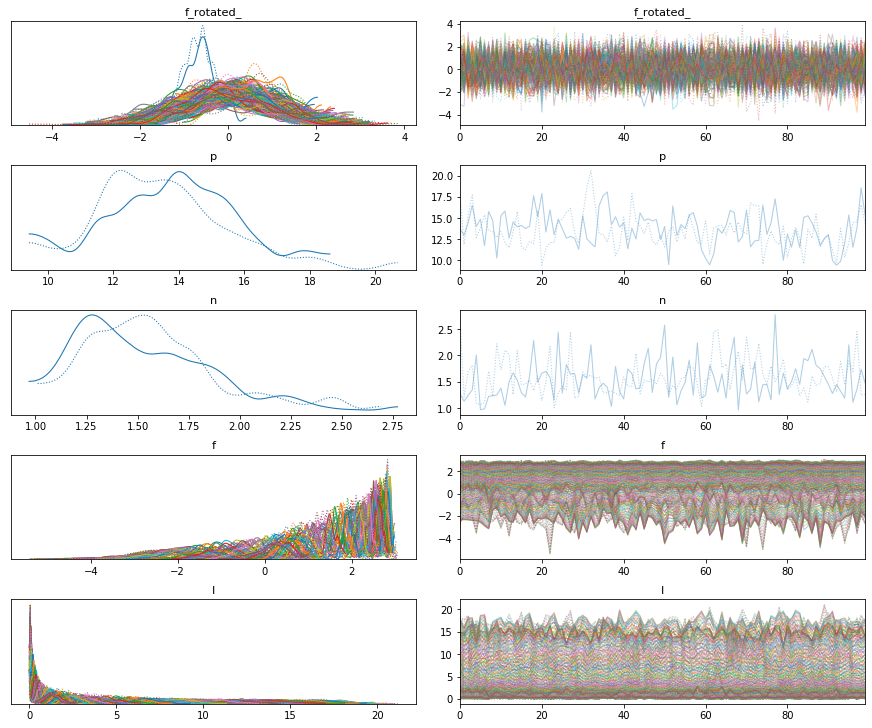

In [13]:
pm.traceplot(trace)

In [14]:
res = pm.trace_to_dataframe(trace)

In [15]:
result = pm.summary(trace)
result.index.tolist()

['f_rotated_[0]',
 'f_rotated_[1]',
 'f_rotated_[2]',
 'f_rotated_[3]',
 'f_rotated_[4]',
 'f_rotated_[5]',
 'f_rotated_[6]',
 'f_rotated_[7]',
 'f_rotated_[8]',
 'f_rotated_[9]',
 'f_rotated_[10]',
 'f_rotated_[11]',
 'f_rotated_[12]',
 'f_rotated_[13]',
 'f_rotated_[14]',
 'f_rotated_[15]',
 'f_rotated_[16]',
 'f_rotated_[17]',
 'f_rotated_[18]',
 'f_rotated_[19]',
 'f_rotated_[20]',
 'f_rotated_[21]',
 'f_rotated_[22]',
 'f_rotated_[23]',
 'f_rotated_[24]',
 'f_rotated_[25]',
 'f_rotated_[26]',
 'f_rotated_[27]',
 'f_rotated_[28]',
 'f_rotated_[29]',
 'f_rotated_[30]',
 'f_rotated_[31]',
 'f_rotated_[32]',
 'f_rotated_[33]',
 'f_rotated_[34]',
 'f_rotated_[35]',
 'f_rotated_[36]',
 'f_rotated_[37]',
 'f_rotated_[38]',
 'f_rotated_[39]',
 'f_rotated_[40]',
 'f_rotated_[41]',
 'f_rotated_[42]',
 'f_rotated_[43]',
 'f_rotated_[44]',
 'f_rotated_[45]',
 'f_rotated_[46]',
 'f_rotated_[47]',
 'f_rotated_[48]',
 'f_rotated_[49]',
 'f_rotated_[50]',
 'f_rotated_[51]',
 'f_rotated_[52]',
 'f

In [16]:
with model:
    ppc = pm.sample_ppc(trace)

/home/danil/.local/lib/python3.6/site-packages/ipykernel_launcher.py:2: DeprecationWarning: sample_ppc() is deprecated.  Please use sample_posterior_predictive()
  
100%|██████████| 200/200 [00:00<00:00, 233.91it/s]


In [21]:
pm.DensityDist()

numpy.ndarray

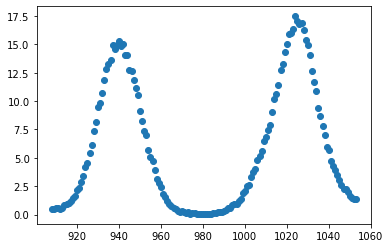

In [56]:
ex=np.reshape(np.mean(ppc['confirmation'],axis=0),[-1]) 
plt.scatter(Gp2_range,ex)

In [ ]:
data['Gp2'].hist(bins=100, figsize=(10,10))